In [47]:

import argparse
import sys
import pandas as pd
import os
sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
from configs import settings
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader
from core_model.train_test import model_forward

set_noise_ratio='0.5'
set_noise_type='symmetric'
#0.5 对称 修改了CRUL,ELR,GJS,finetune,wfisher的名字为cifar-resnet18_restore;发现fisher_new,FT_prune_bi没用

#raw疑似pretrain?
set_basic_name='retrain,retrain_ls,retrain_sam,raw'
set_LNL_name='Coteaching,Coteachingplus,Decoupling,DISC,ELR,GJS,JoCoR,NegativeLearning,PENCIL'
set_MU_name='finetune,FT,FT_l1,FT_prune,GA,GA_l1,wfisher'
set_OUR_name='CRUL'

set_uni_name=f"{set_basic_name},{set_LNL_name},{set_MU_name},{set_OUR_name}"
set_uni_name='ELR'
set_dataset='cifar-10'
set_model='cifar-resnet18'
set_model_suffix='restore'
set_batch_size=64



def execute():
    case = settings.get_case(set_noise_ratio,set_noise_type)
    uni_names = set_uni_name
    uni_names = [uni_names] if uni_names is None else uni_names.split(",")
    num_classes = settings.num_classes_dict[set_dataset]

    loaded_model = load_custom_model(set_model, num_classes, load_pretrained=False)
    model = ClassifierWrapper(loaded_model, num_classes)

    _, _, test_loader = get_dataset_loader(
        set_dataset,
        "test",
        None,
        batch_size=set_batch_size,
        shuffle=False,
    )
    _, _, noisy_loader = get_dataset_loader(
        set_dataset,
        "train_noisy",
        case,
        batch_size=set_batch_size,
        shuffle=False,
        label_name="train_noisy_true_label"
    )
    
    results_data=[]

    for uni_name in uni_names:
        print(f"Evaluating {uni_name}:")
        dict_temp={}
        model_ckpt_path = settings.get_ckpt_path(
            set_dataset,
            case,
            set_model,
            model_suffix=set_model_suffix,
            unique_name=uni_name,
        )
        print(f"Loading model from {model_ckpt_path}")
        checkpoint = torch.load(model_ckpt_path)
        model.load_state_dict(checkpoint, strict=False)
        # print(f"Evaluating test_data:")
        # results, embedding = model_test(test_loader, model)
        # print("Results: %.4f" % results)
        
        print(f"Evaluating train_noisy_data:")
        n_results, n_embedding = model_test(noisy_loader, model)
        # print("Results: %.4f" % results)
        print("Results: ", n_results)
        dict_temp={'uni_name':uni_name,**n_results}
        results_data.append(dict_temp)
    
    df=pd.DataFrame(results_data)
    return df        



def model_test(data_loader, model, device="cuda"):
    eval_results = {}

    predicts, probs, embedding, labels = model_forward(
        data_loader, model, device, output_embedding=True, output_targets=True
    )
    print(predicts,len(predicts))
    # global acc
    global_acc = np.mean(predicts == labels)
    eval_results["global"] = global_acc.item()

    # class acc
    label_list = sorted(list(set(labels)))
    for label in label_list:
        cls_index = labels == label
        class_acc = np.mean(predicts[cls_index] == labels[cls_index])
        eval_results["label_" + str(label.item())] = class_acc.item()

    return eval_results, embedding

In [48]:
#把所有模型的结果存到一个dataframe 里面
results=pd.DataFrame()
results=execute()

Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy
Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.5_nt_symmetric_cvpr/train_noisy_data.npy
Evaluating retrain:
Loading model from /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.5_nt_symmetric_cvpr/retrain/cifar-resnet18_restore.pth
Evaluating train_noisy_data:


<ipython-input-47-90344c5226be>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_ckpt_path)


[0 0 0 ... 9 9 9] 15000
Results:  {'global': 0.8006, 'label_0': 0.8241539482415395, 'label_1': 0.9116309291747888, 'label_2': 0.7294038847957133, 'label_3': 0.6895861148197597, 'label_4': 0.7688772160210111, 'label_5': 0.696969696969697, 'label_6': 0.8295148247978437, 'label_7': 0.7962340282447882, 'label_8': 0.8756648936170213, 'label_9': 0.8770654329147389}
Evaluating retrain_ls:
Loading model from /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.5_nt_symmetric_cvpr/retrain_ls/cifar-resnet18_restore.pth
Evaluating train_noisy_data:
[0 0 4 ... 9 9 8] 15000
Results:  {'global': 0.7972666666666667, 'label_0': 0.8281353682813537, 'label_1': 0.9129304743339831, 'label_2': 0.7347622237106497, 'label_3': 0.6555407209612817, 'label_4': 0.757715036112935, 'label_5': 0.7073002754820936, 'label_6': 0.8301886792452831, 'label_7': 0.7995965030262273, 'label_8': 0.8683510638297872, 'label_9': 0.8717779246530073}
Evaluating retrain_sam:
Loading model from /nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.5_nt_symme

In [6]:
results.to_csv('visualize_results_cvpr/cifar10_0.5_sym.csv')
# results.to_csv('visualize_results_cvpr/flower_0.5_sym.csv')
# results.to_csv('visualize_results_cvpr/cifar100_0.5_asym.csv')
# results.to_csv('visualize_results_cvpr/pet_0.5_asym.csv')

,uni_name,global,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9
0,retrain,0.800600,0.824154,0.911631,0.729404,0.689586,0.768877,0.696970,0.829515,0.796234,0.875665,0.877065
1,retrain_ls,0.797267,0.828135,0.912930,0.734762,0.655541,0.757715,0.707300,0.830189,0.799597,0.868351,0.871778
2,retrain_sam,0.882467,0.905773,0.942820,0.797723,0.791055,0.863427,0.803030,0.921833,0.907196,0.963431,0.923992
3,raw,0.627533,0.459190,0.647173,0.219022,0.726302,0.684176,0.548209,0.904313,0.452589,0.870346,0.758757
4,Coteaching,0.723733,0.811546,0.877843,0.540522,0.544059,0.688116,0.622590,0.874663,0.682582,0.775266,0.812293
5,Coteachingplus,0.723000,0.810883,0.888239,0.547890,0.533378,0.697308,0.618457,0.872642,0.679892,0.773936,0.799075
6,Decoupling,0.671533,0.472462,0.857050,0.797723,0.635514,0.414970,0.462810,0.803908,0.561533,0.849069,0.852611
7,DISC,0.782000,0.820836,0.857700,0.758875,0.535381,0.710440,0.679752,0.894879,0.796907,0.884973,0.875744
8,ELR,0.782000,0.820836,0.857700,0.758875,0.535381,0.710440,0.679752,0.894879,0.796907,0.884973,0.875744
9,GJS,0.782000,0.820836,0.857700,0.758875,0.535381,0.710440,0.679752,0.894879,0.796907,0.884973,0.875744


In [25]:
#set corresponding color for each uni_name
import matplotlib.pyplot as plt
set_basic_names = ['retrain', 'retrain_ls', 'retrain_sam', 'raw'] 
set_LNL_names = ['Coteaching', 'Coteachingplus', 'Decoupling', 'DISC', 'ELR', 'GJS', 'JoCoR', 'NegativeLearning', 'PENCIL'] 
set_MU_names = ['finetune', 'FT', 'FT_l1', 'FT_prune', 'GA', 'GA_l1', 'wfisher'] 
set_OUR_names = ['CRUL']

# 生成配色方案 
set_basic_colors = plt.cm.Blues(np.linspace(0.3, 0.5, len(set_basic_names))) 
set_LNL_colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(set_LNL_names))) 
set_MU_colors = plt.cm.Purples(np.linspace(0.3, 0.7, len(set_MU_names))) 
set_OUR_colors = ['#ff1493'] # 深粉色调

# 创建字典 
uni_color_dict = {}
# 将颜色和 uni_name 配对 
for name, color in zip(set_basic_names, set_basic_colors): 
    uni_color_dict[name] = color 
for name, color in zip(set_LNL_names, set_LNL_colors): 
    uni_color_dict[name] = color 
for name, color in zip(set_MU_names, set_MU_colors): 
    uni_color_dict[name] = color 
for name, color in zip(set_OUR_names, set_OUR_colors): 
    uni_color_dict[name] = color

In [26]:
uni_color_dict.keys()

dict_keys(['retrain', 'retrain_ls', 'retrain_sam', 'raw', 'Coteaching', 'Coteachingplus', 'Decoupling', 'DISC', 'ELR', 'GJS', 'JoCoR', 'NegativeLearning', 'PENCIL', 'finetune', 'FT', 'FT_l1', 'FT_prune', 'GA', 'GA_l1', 'wfisher', 'CRUL'])

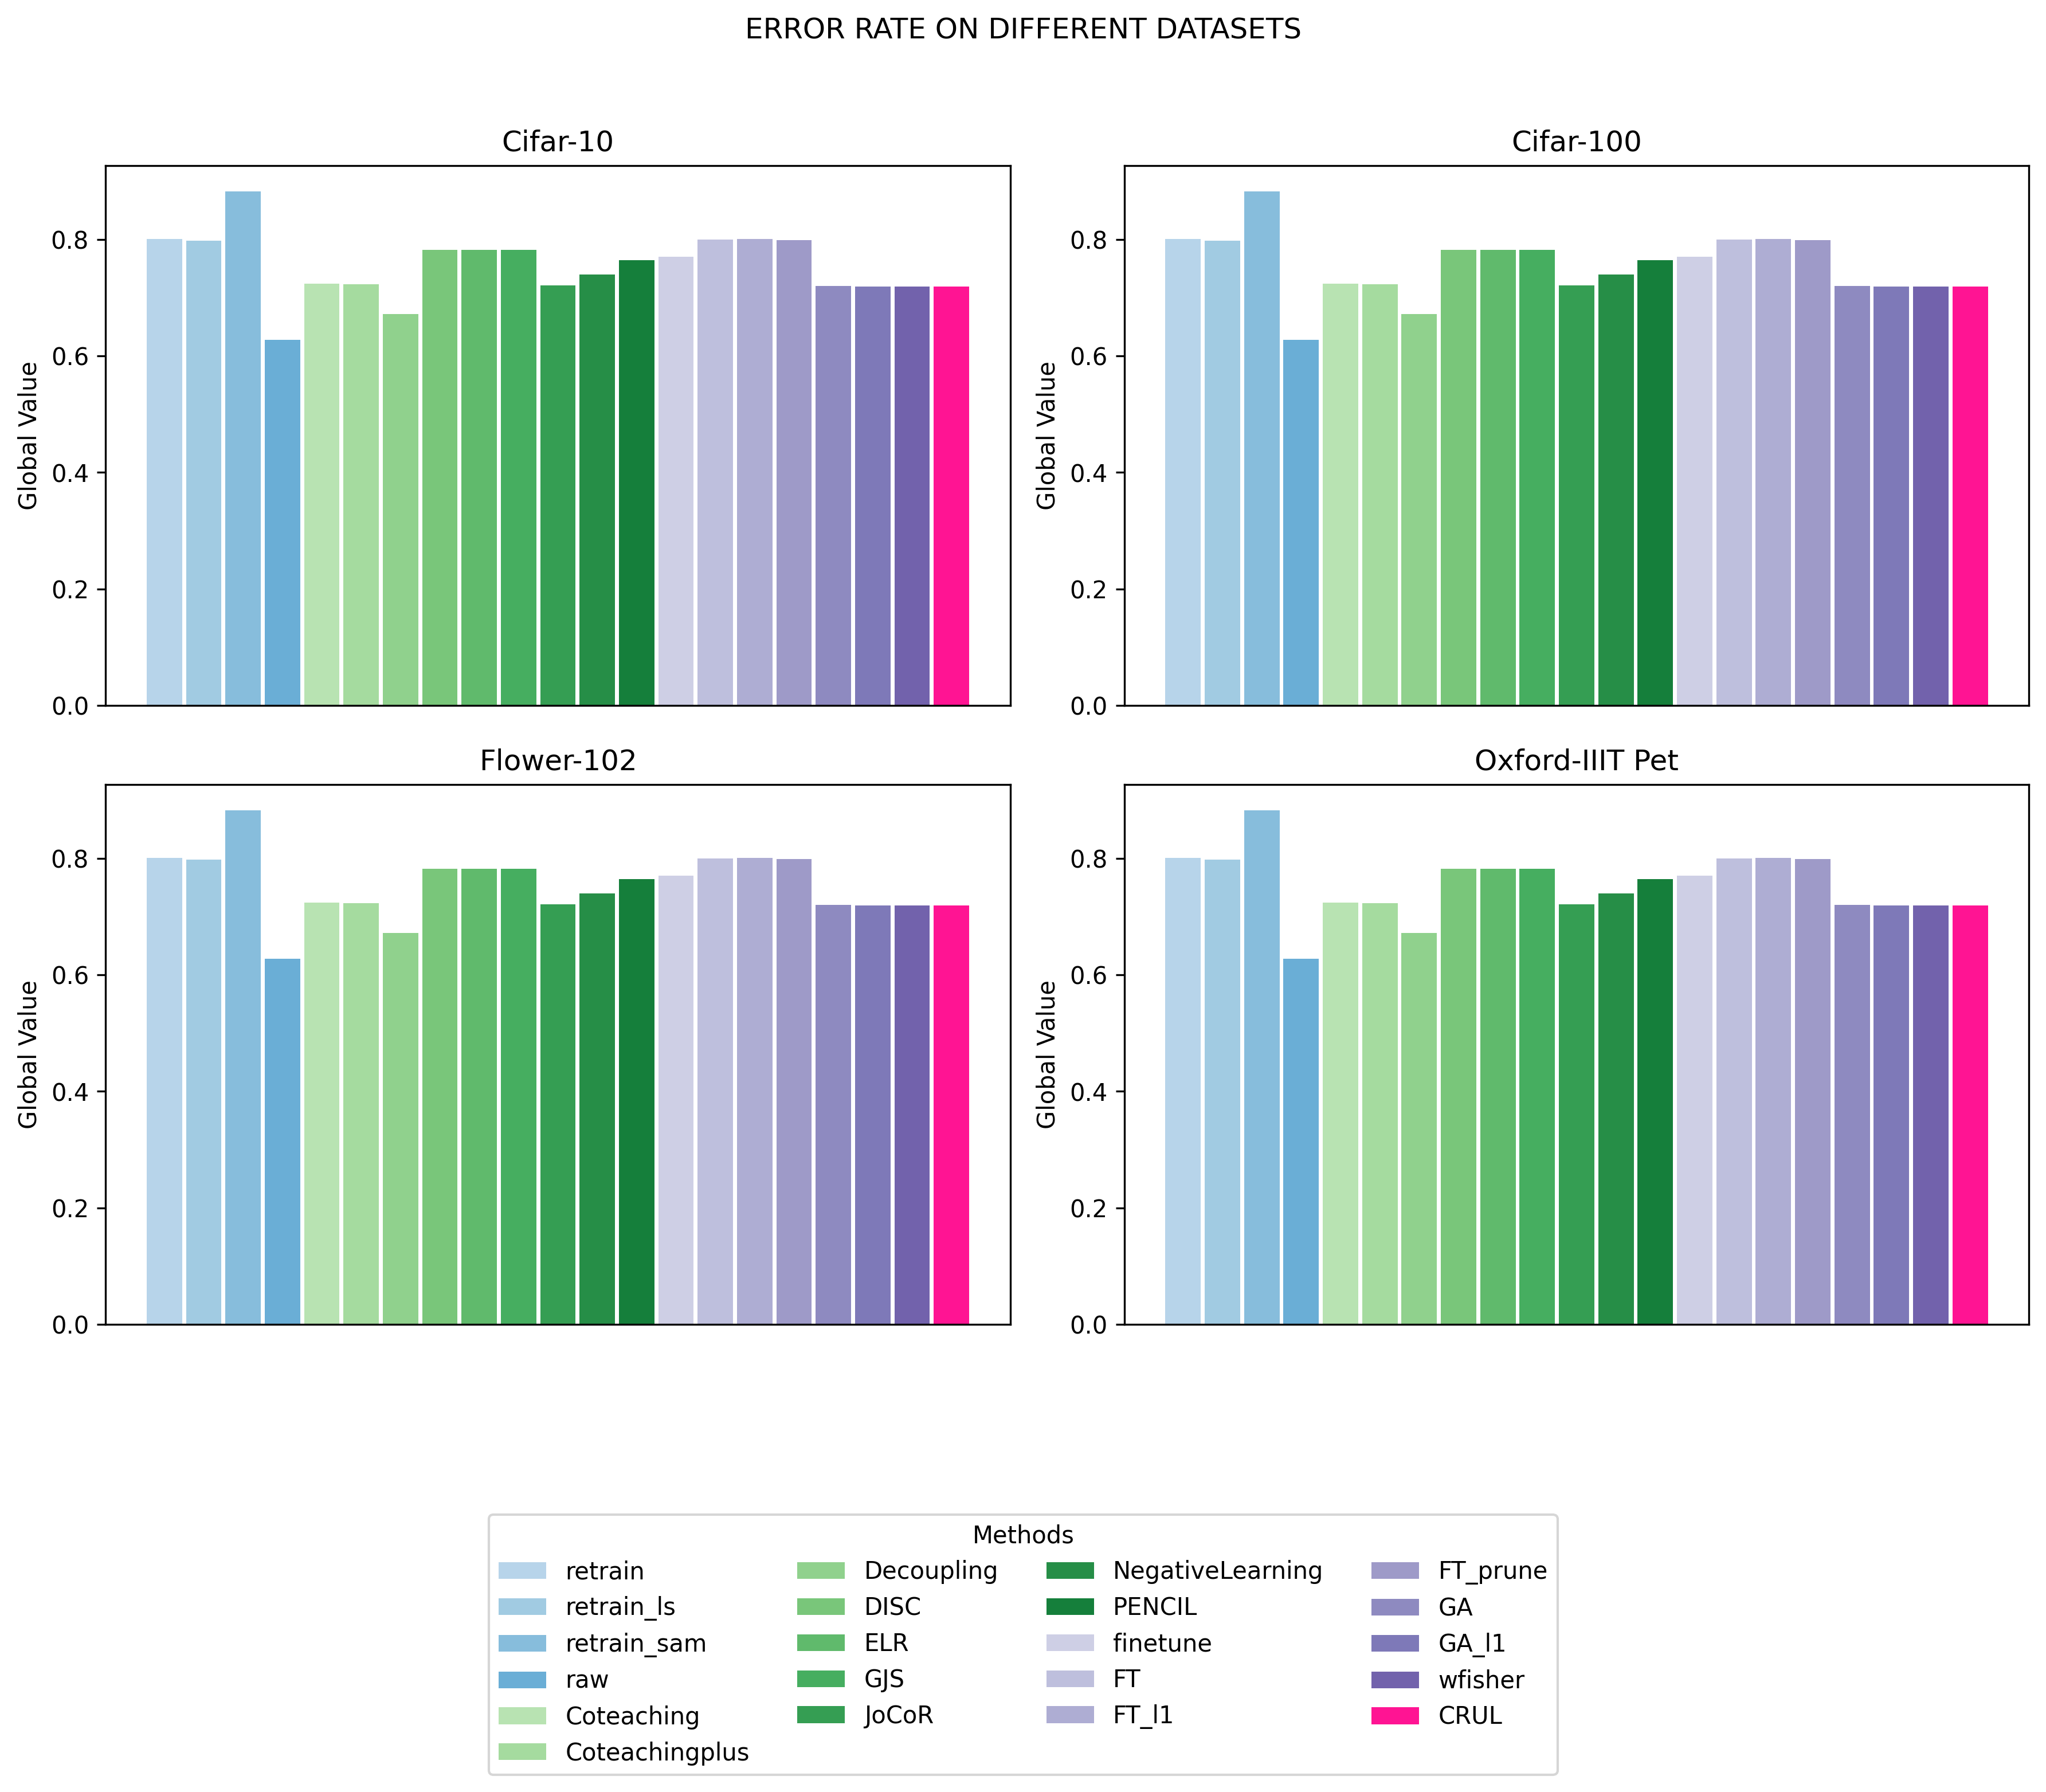

In [27]:
import matplotlib.pyplot as plt
dataframes = [results,results,results,results] 
labels = ['Cifar-10', 'Cifar-100', 'Flower-102', 'Oxford-IIIT Pet'] 
fig, axs = plt.subplots(2, 2, figsize=(12, 8)) 

for i, (df, label) in enumerate(zip(dataframes, labels)):
    ax = axs[i // 2, i % 2]
    for j, (method, global_val) in enumerate(zip(df['uni_name'], df['global'])):
        ax.bar(method, global_val, color=uni_color_dict[method], label=method if i == 0 else "",width=0.9) 
    ax.set_title(f'{label}')
    # ax.set_xlabel('Algorithm') 
    ax.set_ylabel('Global Value')
    ax.set_xticks([])
    # ax.grid(True,linestyle='--',alpha=0.7)

handles, labels = [], [] 
for ax in axs.flat: 
    h, l = ax.get_legend_handles_labels() 
    handles.extend(h) 
    labels.extend(l) 

n_cols = 4 # 图例列数 
fig.legend(handles, labels, loc='upper center', ncol=n_cols, bbox_to_anchor=(0.5, -0.1), title="Methods")

#整体标题
fig.suptitle('ERROR RATE ON DIFFERENT DATASETS')

# 调整布局 
plt.tight_layout(rect=[0, 0, 1, 0.96])  
fig.set_dpi(300)
# 留出顶部空间给图例 
plt.show()


In [ ]:
# #柱状图

# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# from math import pi
# import numpy as np

# # Defining method categories
# lnl_methods = ['Coteaching', 'Coteachingplus', 'Decoupling', 'NegativeLearning', 'PENCIL']
# unlearning_methods = ['raw', 'GA', 'FT', 'FT_l1', 'FT_prune', 'retrain', 'retrain_ls', 'retrain_sam']

# baseline_methods = ['pretrain', 'inc_train'] 

# datasets = ['cifar-10_sym', 'cifar-100_asym', 'flower-102_sym', 'pet-37_asym']
# display_name_dataset = {
#     'cifar-10_sym' : 'Cifar-10', 
#     'cifar-100_asym': 'Cifar-100', 
#     'flower-102_sym': 'Flower-102', 
#     'pet-37_asym' : 'Oxford-IIIT Pet'
# }

# display_name_legend = {
#     'pretrain' : 'PreTrain', 
#     'inc_train' : 'IncTrain', 
#     'finetune': 'FineTune', 
#     'Coteaching' : 'CoTe.', 
#     'Coteachingplus': 'CoTe.+', 
#     'Decoupling': 'Decoup.', 
#     'NegativeLearning' : 'NegLn.', 
#     'PENCIL' : 'PENCIL', 
#     'raw': 'Raw', 
#     'GA': 'GA', 
#     'FT': 'FT', 
#     'FT_l1': 'FT-$l_{1}$', 
#     'FT_prune' : 'FT$_p$', 
#     'retrain' : 'ReT', 
#     'retrain_ls' : 'ReT$_L$', 
#     'retrain_sam' : 'ReT$_S$', 
#     'CRUL' : 'CRUL'
# }

# # Creating a bar chart to compare accuracy across methods for each dataset
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# axes = axes.flatten()
# width = 0.7  # Increased the width of the bars for better visibility
# tfs = 12 # x/y-ticks font size
# title_size = 18 # Title font size
# lfs = 14 # Legend-font-size

# # Colors for different categories
# baseline_colors = ['lightgrey', 'darkgrey', 'silver']
# lnl_colors = plt.cm.Blues(np.linspace(0.4, 1, 5))
# unlearning_colors = plt.cm.Greens(np.linspace(0.4, 1, 8))
# crul_color = 'red'


# # Plotting each dataset in a separate subplot
# for idx, dataset in enumerate(datasets):
#     ax = axes[idx]
#     x = np.arange(len(baseline_methods) + len(lnl_methods) + len(unlearning_methods) + 1)  # the label locations
    
#     # Plotting baseline methods (pretrain, noise-train, finetune)
#     for i, method in enumerate(baseline_methods):
#         ax.bar(x[i], sheet1_df.loc[dataset, method], width, label=method, color=baseline_colors[i], edgecolor='black', hatch=['//', '..'][i]) # 仅保留 pretrain和inc_train

#     # Plotting LNL methods
#     for i, method in enumerate(lnl_methods):
#         ax.bar(x[len(baseline_methods) + i], sheet1_df.loc[dataset, method], width, label=method, color=lnl_colors[i], edgecolor='black')

#     # Plotting Unlearning methods
#     for i, method in enumerate(unlearning_methods):
#         ax.bar(x[len(baseline_methods) + len(lnl_methods) + i], sheet1_df.loc[dataset, method], width, label=method, color=unlearning_colors[i], edgecolor='black')

#     ax.bar(x[-1], sheet1_df.loc[dataset, 'CRUL'], width, label='CRUL', color=crul_color, edgecolor='black')

#     ax.set_title(f'{display_name_dataset[dataset]}', fontsize=title_size, fontfamily="serif", weight="bold")

#     ax.set_xticks([]) # 关闭x轴显示


# # --------------------------------------------------------------------------------- #
# """
# 手动修正四个子图各自的坐标值范围。
# # """
# # # Cifar-10
# axes[0].set_ylim(40, 85)
# axes[0].set_yticks(np.arange(40, 91, 15))
# axes[0].set_yticklabels(
#             np.arange(40, 91, 15),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )


# # Cifar-100
# axes[1].set_ylim(50, 70)
# axes[1].set_yticks(np.arange(50, 71, 5))
# axes[1].set_yticklabels(
#             np.arange(50, 71, 5),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )

# # Flower-102
# axes[2].set_ylim(50, 95)
# axes[2].set_yticks(np.arange(50, 96, 15))
# axes[2].set_yticklabels(
#             np.arange(50, 96, 15),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )


# # Pet-37
# axes[3].set_ylim(70, 95)
# axes[3].set_yticks(np.arange(70, 96, 10))
# axes[3].set_yticklabels(
#             np.arange(70, 96, 10),
#             fontsize=tfs,
#             rotation=90,
#             va="center",
#             fontfamily="serif",
#             weight="bold",
#         )


# handles, legend_labels = fig.axes[0].get_legend_handles_labels()

# labels = [display_name_legend[ll] for ll in legend_labels]

# legend_font_properties = fm.FontProperties(
#                                         #    weight='bold', 
#                                            size=lfs)

# from matplotlib.lines import Line2D
# empty_handle = Line2D([], [], color='none')  # 创建一个空的占位符

# # 在第二个 legend 之后插入占位符
# handles.insert(2, empty_handle)
# labels.insert(2, '')  # 对应的标签留空

# fig.legend(handles, labels, loc='lower center', 
#            bbox_to_anchor=(0.5, -0.05), ncol=6,
#            prop=legend_font_properties)

# fig.tight_layout(rect=[0, 0.1, 1, 1])

# plt.show()

In [ ]:
# #雷达图
# import numpy as np
# import matplotlib.pyplot as plt
# from math import pi

# # CIFAR-10的标签
# labels = ['label0', 'label1', 'label2', 'label3', 'label4', 'label5', 'label6', 'label7', 'label8', 'label9']

# # 假设数据
# our_method_scores = [0.85, 0.88, 0.82, 0.80, 0.83, 0.87, 0.84, 0.86, 0.81, 0.89]
# resnet18_scores = [0.75, 0.77, 0.74, 0.70, 0.73, 0.78, 0.76, 0.75, 0.72, 0.74]

# # 设置雷达图的角度
# num_vars = len(labels)

# # 角度计算（每个标签对应一个角度）
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# # 将数据循环到开始位置，这样雷达图会闭合
# our_method_scores += our_method_scores[:1]
# resnet18_scores += resnet18_scores[:1]
# angles += angles[:1]

# # 创建雷达图
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # 画 Our method 和 ResNet18 的雷达图
# ax.plot(angles, our_method_scores, color='blue', linewidth=2, label='Our method')
# ax.fill(angles, our_method_scores, color='blue', alpha=0.25)

# ax.plot(angles, resnet18_scores, color='red', linewidth=2, label='ResNet18')
# ax.fill(angles, resnet18_scores, color='red', alpha=0.25)

# # 设置标签（CIFAR-10的类别）
# ax.set_yticklabels([])
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(labels, fontsize=10)

# # 添加标题
# ax.set_title('Comparison of Our method and ResNet18 on CIFAR-10', size=14, color='black', y=1.1)

# # 添加图例
# ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))

# # 显示图形
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 方法名和对应的准确率（根据实际结果替换这些数据）
# methods = ['Our method', 'ResNet18', 'Method A', 'Method B']
# accuracies = [0.85, 0.75, 0.78, 0.80] # 假设这四种方法在 CIFAR-10 上的准确率

# # 设置柱状图的宽度和位置
# x = np.arange(len(methods)) # 方法的数量
# width = 0.5 # 每个柱子的宽度

# # 创建柱状图
# fig, ax = plt.subplots(figsize=(8, 6))

# # 绘制柱状图
# bars = ax.bar(x, accuracies, width, color=['blue', 'red', 'green', 'orange'])

# # 设置标签和标题
# ax.set_xlabel('Methods', fontsize=12)
# ax.set_ylabel('Accuracy', fontsize=12)
# ax.set_title('Comparison of Different Methods on CIFAR-10', fontsize=14)
# ax.set_xticks(x) # 设置 X 轴刻度位置
# ax.set_xticklabels(methods, fontsize=12) # 设置 X 轴标签

# # 添加柱状图的数值标签
# for bar in bars:
#     height = bar.get_height()
#     ax.annotate(f'{height:.2f}', # 显示每个柱的准确率
#     xy=(bar.get_x() + bar.get_width() / 2, height),
#     xytext=(0, 3), # 偏移量
#     textcoords="offset points",
#     ha='center', va='bottom', fontsize=10)

# # 显示图形
# plt.show()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader
from tqdm import tqdm
from configs import settings
import logging
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader, BaseTensorDataset
from core_model.train_test import model_forward

# 设置设备和日志
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def extract_features(feature_extractor, data_loader):
    """
    提取数据的嵌入特征和标签。
    """
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    try:
        return np.concatenate(features), np.concatenate(labels)
    except ValueError:
        logger.error("Error concatenating features or labels; check data loader and model output.")
        return None, None

def retrieve(gallery_feats, query_feats, top_k=10):
    """
    计算相似度并返回前 top-k 的索引。
    """
    try:
        sims = cosine_similarity(query_feats, gallery_feats)
        indices = np.argsort(-sims, axis=1)[:, :top_k]
        sim_scores = np.take_along_axis(sims, indices, axis=1)
        return indices, sim_scores
    except ValueError as e:
        logger.error(f"Error in similarity calculation: {e}")
        return None, None

def calculate_map(indices, gallery_labels, query_labels):
    """
    计算 mAP 值。
    """
    if indices is None:
        logger.warning("No indices to calculate mAP. Skipping.")
        return 0.0
    ap_list = []
    for i in range(len(query_labels)):
        query_label = query_labels[i]
        relevant = (gallery_labels[indices[i]] == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    return np.mean(ap_list) if ap_list else 0.0

def visualize_retrieval(query_data, query_labels, gallery_data, gallery_labels, query_idx, retrieved_indices, sim_scores, dataset_name="cifar-10"):
    """
    可视化检索结果，将查询图像与检索结果并列显示。
    """
    if retrieved_indices is None or sim_scores is None:
        logger.warning("No retrieval results to display. Skipping visualization.")
        return
    
    fig, axs = plt.subplots(1, len(retrieved_indices) + 1, figsize=(15, 3))
    
    # 处理查询图像
    query_img = recover_img(query_data[query_idx], dataset_name)
    axs[0].imshow(np.transpose(query_img, (1, 2, 0)))
    axs[0].set_title(f"Query\nLabel: {query_labels[query_idx]}", color="purple")
    axs[0].axis("off")

    # 处理检索结果
    for i, idx in enumerate(retrieved_indices):
        img = recover_img(gallery_data[idx], dataset_name)
        label = gallery_labels[idx]
        axs[i + 1].imshow(np.transpose(img, (1, 2, 0)))
        axs[i + 1].set_title(f"Label: {label} ({sim_scores[i]:.2f})", color="green" if label == query_labels[query_idx] else "red")
        axs[i + 1].axis("off")

    plt.show()

def recover_img(img, dataset_name):
    """
    恢复归一化的图像，用于可视化。
    """
    if dataset_name == "cifar-10":
        means, stds = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis], np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    elif dataset_name == "cifar-100":
        means, stds = np.array([0.5071, 0.4865, 0.4409])[:, np.newaxis, np.newaxis], np.array([0.2673, 0.2564, 0.2762])[:, np.newaxis, np.newaxis]
    elif dataset_name == "pet-37":
        means, stds = np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis], np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]
    else:
        raise NotImplementedError(f"Normalization for dataset {dataset_name} not implemented.")
    return np.clip(img * stds + means, 0, 1)

def evaluate_image_retrieval(dataset_name, model_name, noise_ratio, noise_type="symmetric", methods=None, top_k=5, query_indices=None):
    """
    执行图像检索任务，包括 mAP 计算和检索结果的可视化。
    """
    assert methods is not None, "请指定方法列表"
    assert query_indices is not None, "请指定查询索引列表"

    case = settings.get_case(noise_ratio, noise_type)
    num_classes = settings.num_classes_dict[dataset_name]

    # 加载数据集
    train_data, train_labels, train_loader = get_dataset_loader(dataset_name, "train", None, None, batch_size=64, shuffle=False)
    test_data, test_labels, test_loader = get_dataset_loader(dataset_name, "test", None, None, batch_size=64, shuffle=False)

    for method in methods:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)

        # 加载模型权重
        model_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_cvpr/{method}/{model_name}_restore.pth"
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint, strict=False)
            logger.info(f"Evaluating model at {model_path}")
        except FileNotFoundError:
            logger.warning(f"Model checkpoint {model_path} not found. Skipping method {method}.")
            continue

        # 提取特征
        feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)
        g_features, g_labels = extract_features(feature_extractor, train_loader)
        q_features, q_labels = extract_features(feature_extractor, test_loader)

        if g_features is None or q_features is None:
            logger.warning("Feature extraction failed; skipping this method.")
            continue

        # 计算 mAP
        indices, sim_scores = retrieve(g_features, q_features, top_k)
        mAP = calculate_map(indices, g_labels, q_labels)
        logger.info(f"mAP for method {method}: {mAP:.4f}")

        # 可视化检索结果
        for query_idx in query_indices:
            retrieved_indices, sim_scores = retrieve(g_features, q_features[query_idx:query_idx+1], top_k)
            if retrieved_indices is not None and sim_scores is not None:
                visualize_retrieval(test_data, test_labels, train_data, train_labels, query_idx, retrieved_indices[0], sim_scores[0], dataset_name)

# 示例用法
if __name__ == "__main__":
    dataset_name = "cifar-10"
    model_name = "efficientnet_s"
    noise_ratio = 0.1
    noise_type = "symmetric"
    methods = ["Coteaching", "Coteachingplus", "JoCoR"]
    query_indices = [0, 1, 2]  # 测试图片索引
    evaluate_image_retrieval(dataset_name, model_name, noise_ratio, noise_type, methods=methods, top_k=5, query_indices=query_indices)
